In [3]:
import xlrd
import pandas as pd
import numpy as np
from math import radians, cos, sin, asin, sqrt
import xlwt
import operator
import copy
from functools import reduce
import sklearn.cluster as sc
import re
import bokeh
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
output_notebook() #导入这个命令之后bokeh的绘画内容都在notebook上显示

# 不用科学计数
# pd.set_option('display.float_format',lambda x : '%.2f' % x)

Loading BokehJS ...

In [16]:
excel_origin=pd.ExcelFile('hair_dryer_verified.xlsx')# 原始数据
hair_dryer_verified=pd.read_excel(excel_origin,'Sheet1')

excel_origin=pd.ExcelFile('microwave_verified.xlsx')# 原始数据
microwave_verified=pd.read_excel(excel_origin,'Sheet1')

excel_origin=pd.ExcelFile('pacifier_verified.xlsx')# 原始数据
pacifier_verified=pd.read_excel(excel_origin,'Sheet1')


# 时间序列分析
首先我们认为对销售量低于（阈值==？）的产品进行时间序列分析是没有意义的，我们只考虑发售时期长和销量明显的产品

In [11]:
pacifier_verified['review_date'] = pd.to_datetime(pacifier_verified['review_date'])

In [12]:
pacifier_verified['review_date'][0]

Timestamp('2015-08-31 00:00:00')

In [5]:
writer=pd.ExcelWriter('pacifier_verified_data.xlsx')
pacifier_verified_246038397.to_excel(writer, 'Sheet1')
writer.save()

NameError: name 'pacifier_verified_246038397' is not defined

In [ ]:
pacifier_verified_246038397.set_index(pacifier_verified_246038397['review_date'],inplace=True)
pacifier_verified_246038397

In [ ]:
starbymonth=pacifier_verified_246038397['star_rating'].groupby([pacifier_verified_246038397['review_date'].dt.year.rename('year'), pacifier_verified_246038397['review_date'].dt.month.rename('month')]).mean()
starbymonth

In [ ]:
longer_ts = pd.Series(np.random.randn(1585 ),
     index=pd.date_range('4/28/2011', periods=1585 ))
longer_ts

In [ ]:
#pacifier_verified_246038397
from bokeh.models import NumeralTickFormatter
p=figure(title="",plot_width=800,plot_height=400,
        x_axis_type="datetime")
p.scatter(pacifier_verified_246038397['review_date'],pacifier_verified_246038397['star_rating'])

#p.xaxis[0].formatter=NumeralTickFormatter()

show(p)

In [ ]:
#pacifier_verified_246038397.iloc[-1,-2]-pacifier_verified_246038397.iloc[0,-2]
pacifier_verified_246038397.iloc[-1,-2]

In [ ]:
from bokeh.palettes import Category20 as palette
p=figure(title="",plot_width=800,plot_height=400,
        x_axis_type="datetime")
product=[
    246038397,
    392768822,
    572944212,
    450475749,
    812583172,
    381226741,
    667171015,
    911821018,
    106521272,
    380619977,
]
color_i=0
for product_i in product:
    #color_i=0
    product=pacifier_verified[pacifier_verified['product_parent']==product_i]
    p.scatter(product['review_date'],product['star_rating'],
              fill_color=palette[20][color_i],
              line_color=None,
              fill_alpha=0.9,
              size=7
              #legend=str(product_i)
             )
    color_i=color_i+1
show(p)

## 结论
确实随着时间推移评分会有差评出现，但是可以看到越是时间越是靠后销量却也更多，可以看excel图表

现在要做的是，把所有有用的数据形成一个excel（总共三组），包含
- 时间戳
- 产品评论总得分
- 产品评星

product文件正好满足后两个要求，所以对product加上时间戳

表格分析的结论：微波炉423421857是爆款，2014年才发售两年就销售冠军而且比别的有量级的差距
行标签	计数项:product_parent
423421857	363
523301568	73
109226352	69
771401205	69
827502283	66
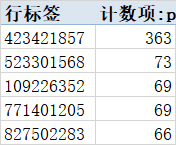

# 关联规则分析解决f题
## 什么是关联规则学习

从大规模数据集中寻找物品间的隐含关系被称作关联分析(associati analysis) 或者 关联规则学习（association rule learning）。关联规则学习的任务是寻找频繁项集frequent itemset。例如我们如果对超市购物清单进行关联规则分析，发现了一个频繁项集{milk,banana}，就说明去超市购物的人经常同时购买这两项东西。
将关联规则学习的思想应用到我们的评论文本分析，我们可以将用户评星和评论的标题（review headline）结合到一起组成一个项集，列如一条评星为4并且评价标题为“I think it is great”的评论，我们可以定义其项集为：
{'4','I','think','it','is','great'}，当然我们会对单词进行一些筛选分析，删去无用的'is','I'等停用词stop_word，得到该评论的项集{'4','great'}

最后我们设定支持度（support），并对我们的一些描述符查询与之相关的项集，寻找出哪些特定质量描述符与评星1，2，3，4，5最为相关

我们的做法：对评论进行筛选，对于headline（可以在前面的假设写上：我们认为headline普遍代表了一条评论的整体取向，评论主体body则是对headline的进一步扩充，所以我们认为headline中的信息足够我们使用），先选出最常见的评语（比如"five star"‘love it’‘great’）。同时我们猜测：出现频次较少的headline可能是由于要么是用了一些生僻的词汇进行评价，要么是写了一个长句子然而特定的质量描述符是蕴藏在其中的，因此我们对频次较少headline的进行拆分处理，再除去其中的停用词（Stop_Word），例如I,of,for,you这种并非描述质量的词汇。最后我们得到一个常见的词汇列表，挑选我们认为合适的词汇$Word$带入原headline中进行字符串匹配并与该评论的评星组成项集：$\{Star_i,Word\},Star_i\in {1,2,3,4,5}$，最后我们挑选出基于该描述符置信度最高的评星Star，我们认为该评分与这一项描述符密切相关，如果该描述符在我们设定的置信度阈值中找不到符合的评星，我们认为它是无关的。

In [9]:
def select_review(data_origin,review_id):
    '''
    计算并存储各类数据共多少类，返回字典，字典长度即数目
    '''
    country={}
    for country_i in range(data_origin.shape[0]):# ii 是从0开始的
        #FIPS_Combined=data_origin.iloc[county_i][5]
        country_id=data_origin.iloc[country_i][review_id]
        if country_id not in country.keys():
            country[country_id]=1
        else :#如果已经在里面了，计算出现频率
            country[country_id]=country[country_id]+1
    return country

In [61]:
pacifier_verified['review_headline']=pacifier_verified.iloc[:,13].str.lower().str.replace(r'[^\w\s]+', '')
pacifier_review=select_review(pacifier_verified,13)
pacifier_review_df=pd.Series(pacifier_review)
pacifier_review_df=pacifier_review_df.sort_values(ascending=False)
#pacifier_review_df

five stars                       1702
four stars                        206
love it                           158
great                             120
three stars                        99
                                 ... 
not newborn size                    1
didnt receive what we ordered       1
best for breast fed babies          1
strong smell of rubber              1
these are awesome                   1
Length: 5144, dtype: int64

In [63]:
pacifier_review_df[pacifier_review_df==1]

it is smaller than i bought it would be but it is just the perfect size for my little man    1
my baby and dog love these                                                                   1
my older daughter used the mam pacifiers but my baby hated those and spit them right out     1
my choice of binky                                                                           1
she hated dr browns                                                                          1
                                                                                            ..
not newborn size                                                                             1
didnt receive what we ordered                                                                1
best for breast fed babies                                                                   1
strong smell of rubber                                                                       1
these are awesome                                 

处理完之后我们挑选一些频数为1的headline来验证我们的结论：“my older daughter used the mam pacifiers but my baby hated those and spit them right out”，可以发现该评论之所以频数太低就是因为描述过于详尽，但其关键字符只有"hated"，所以我们对其进行拆分，并过滤掉无用的停用词。

In [25]:
pacifier_review=list(pacifier_review_df.index)
pacifier_review_=pd.DataFrame({'review':pacifier_review,'frequency':list(pacifier_review_df)},index=np.arange(5144))
pacifier_review_df=pacifier_review_
pacifier_review_df

,review,frequency
0,five stars,1702
1,four stars,206
2,love it,158
3,great,120
4,three stars,99
...,...,...
5139,not newborn size,1
5140,didnt receive what we ordered,1
5141,best for breast fed babies,1
5142,strong smell of rubber,1


In [27]:
valueOfFrequency1=pacifier_review_df[pacifier_review_df['frequency']==1]
valueOfFrequency1

,review,frequency
459,it is smaller than i bought it would be but it...,1
460,my baby and dog love these,1
461,my older daughter used the mam pacifiers but m...,1
462,my choice of binky,1
463,she hated dr browns,1
...,...,...
5139,not newborn size,1
5140,didnt receive what we ordered,1
5141,best for breast fed babies,1
5142,strong smell of rubber,1


In [35]:
import nltk
from nltk.corpus import stopwords
stopwords.words('english')
#print (stopwords.words() [620:680])
en_stops = set(stopwords.words('english'))

In [42]:
# 拆分并入库统计
def split_review_AndDeleteStop(data,feature_id):# feature_id 表示在哪一列
    total_word={}
    for i in range(len(data)):
        review=data.iloc[i,feature_id]
        word_list=review.split()
        ## 删除停用词
        for word in word_list:
            if word not in en_stops:
        #for word in word_list:
                if word not in total_word.keys():
                    total_word[word]=1
                else :#如果已经在里面了，计算出现频率
                    total_word[word]=total_word[word]+1
            
    return total_word

In [43]:
review=valueOfFrequency1.iloc[0,0]
total_word1=split_review_AndDeleteStop(valueOfFrequency1,0)
total_word1_Se=pd.Series(total_word1)
total_word1_Se=total_word1_Se.sort_values(ascending=False)

In [58]:
total_word1_index=list(total_word1_Se.index)
total_word1_df=pd.DataFrame({'word':total_word1_index,'frequency':list(total_word1_Se)},index=np.arange(len(total_word1_Se)))
total_word1_df

,word,frequency
0,baby,535
1,great,492
2,pacifier,414
3,love,360
4,pacifiers,250
...,...,...
2588,wrapped,1
2589,manufacturers,1
2590,discolors,1
2591,exemption,1


In [59]:
total_word1_df.drop(index=np.arange(20,2593),inplace=True)
total_word1_df

,word,frequency
0,baby,535
1,great,492
2,pacifier,414
3,love,360
4,pacifiers,250
...,...,...
195,absolutely,14
196,durable,14
197,keeps,14
198,cool,13


In [170]:
writer=pd.ExcelWriter('total_word_df.xlsx')
total_word1_df.to_excel(writer, 'Sheet1')
writer.save()

In [66]:
pacifier_verified

,Unnamed: 0,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,degree
0,0,US,40626522,R1A3ZUBR8TSAKY,B00793CZAE,572944212,"mary meyer wubbanub plush pacifier, lamb",Baby,5,0,0,N,Y,love this,Perfect match for the Gund Huggybuddy I bought...,8/31/2015,0.000000
1,1,US,16290022,RLJNYBK4FGBYX,B003PCYMP4,911821018,wubbanub lamb infant pacifier,Baby,5,0,0,N,Y,love,My little girl love this paci contraption!,8/31/2015,0.000000
2,2,US,10216509,R26QCW75C4JDOK,B003CK3LDI,392768822,wubbanub infant pacifier - giraffe,Baby,5,0,0,N,Y,five stars,My son loves this one and will only sleep if h...,8/31/2015,0.000000
3,3,US,114040,R2E7N0TVLUHUDR,B003CK3LDI,392768822,wubbanub infant pacifier - giraffe,Baby,5,0,0,N,Y,five stars,Perfect,8/31/2015,0.000000
4,4,US,27971579,R1SO9VMCIGZX3U,B003PCYMP4,911821018,wubbanub lamb infant pacifier,Baby,5,0,0,N,Y,five stars,Amazing addition to the nursery!,8/31/2015,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9515,9785,US,39492865,R26FUVIN4EY33Q,B000NP3QMQ,519841015,skip hop pacifier pocket,Baby,4,7,11,N,Y,just what i expected,"Nothing exciting here, just a pacifier holder....",7/28/2007,0.022876
9516,9786,US,52854915,R2IN20D4UHQHF0,B00067AUNY,957640647,"dexbaby womb sounds bear audio pacifier, brown...",Baby,1,3,12,N,Y,womb bear,I bought this for my 5 week old twin boys hopi...,6/12/2007,0.009804
9517,9787,US,11926122,R1LW372P5S0MTM,B000EGZ2SA,735580975,avent orthodontic translucent silicone pacifie...,Baby,5,2,5,N,Y,clear is cool,I like that these are clear. Unfortunately my...,1/3/2007,0.006536
9518,9788,US,51107658,R3D0W5VNNJN2L1,B00007C65S,51313971,munchkin deluxe bottle and food warmer with p...,Baby,1,4,11,N,Y,this thing is horrid,I'm currently in the process of adopting my so...,11/18/2006,0.013072


In [91]:
pacifier_verified['review_body']=pacifier_verified.iloc[:,13].str.lower().str.replace(r'[^\w\s]+', '')
pattern='disappointed'
star_list=[]
for i in range(len(pacifier_verified)):
    headbody=str(pacifier_verified.iloc[i,14])
    if re.search(pattern,headbody):
        star=str(pacifier_verified.iloc[i,8])
        star_list.append(star)

In [92]:
#star_dic=select_review(star_list)
#star_dic

In [93]:
def calculate_prob(data_origin):# list needed
    '''
    计算并存储各类数据共多少类，返回字典，字典长度即数目
    '''
    country={}
    for country_i in data_origin:# ii 是从0开始的
        #FIPS_Combined=data_origin.iloc[county_i][5]
        #country_id=country_i
        if country_i not in country.keys():
            country[country_i]=1
        else :#如果已经在里面了，计算出现频率
            country[country_i]=country[country_i]+1
            
    return country

In [94]:
star_dic=calculate_prob(star_list)
star_dic

{'2': 8, '1': 20, '4': 2, '3': 4, '5': 2}

In [96]:
star_dic['1']+star_dic['2']+star_dic['3']+star_dic['4']+star_dic['5']

20

In [109]:
'2' not in star_dic.keys()

False

In [122]:
def theFrequency(star_dic):
    if '1' not in star_dic.keys():
        star_dic['1']=0
        
    if '2' not in star_dic.keys():
        star_dic['2']=0
        
    if '3' not in star_dic.keys():
        star_dic['3']=0
        
    if '4' not in star_dic.keys():
        star_dic['4']=0
        
    if '5' not in star_dic.keys():
        star_dic['5']=0
        
    frequency=[]
    total=star_dic['1']+star_dic['2']+star_dic['3']+star_dic['4']+star_dic['5']
    for i in range(1,6):
        score=star_dic[str(i)]/total
        frequency.append(score)
    print(frequency)
    return frequency

In [152]:
def patternToFrequency(pattern,pacifier_verified):#pattern is string,the review body of pacifier_verified need 小写
#    pattern='disappointed'
    pacifier_verified['review_body']=pacifier_verified.iloc[:,14].str.lower().str.replace(r'[^\w\s]+', '')
    star_list=[]
    for i in range(len(pacifier_verified)):
        headbody=str(pacifier_verified.iloc[i,14])
        if re.search(pattern,headbody):
            star=str(pacifier_verified.iloc[i,8])
            star_list.append(star)
    star_dic=calculate_prob(star_list)
    frequency=theFrequency(star_dic)
    return frequency

In [124]:
patternToFrequency('disappointed',pacifier_verified)

[0.5555555555555556, 0.2222222222222222, 0.1111111111111111, 0.05555555555555555, 0.05555555555555555]


In [347]:
from bokeh.models import ColumnDataSource
from bokeh.palettes import Spectral6

def showStarDistribution(frequency,title):#the return of patternToFrequency
    star=['1','2','3','4','5']
    source = ColumnDataSource(data=dict(star=star, counts=frequency, 
                                        color=Spectral6))

    p = figure(x_range=star, plot_height=250, title=title,
               toolbar_location=None,tools = "pan,wheel_zoom,box_zoom,reset,save",
              # toolbar_location="below"
              )

    #p = figure(x_range=fruits, y_range=(0,9), plot_height=250, title="Fruit Counts",
    #           toolbar_location=None, tools="")

    p.vbar(x='star', top='counts', width=0.9, color='color', legend_field="star", source=source)

    p.xgrid.grid_line_color = None
    p.legend.orientation = "horizontal"
    p.legend.location = "top_center"

    show(p)

In [185]:
showStarDistribution(patternToFrequency('disappointed',pacifier_verified),'disappointed')

[0.5555555555555556, 0.2222222222222222, 0.1111111111111111, 0.05555555555555555, 0.05555555555555555]


In [227]:
showStarDistribution(patternToFrequency('junk',pacifier_verified),'junk')

[0.5, 0.0, 0.25, 0.25, 0.0]


## 挑选10个常见情感词汇对pacifier数据集进行识别

In [342]:
review_list=['disappointed','poor','ok','satisfied','perfect']
for review in review_list:
    showStarDistribution(patternToFrequency(review,pacifier_verified),'pacifier：'+review)

[0.5555555555555556, 0.2222222222222222, 0.1111111111111111, 0.05555555555555555, 0.05555555555555555]


[0.5, 0.3333333333333333, 0.08333333333333333, 0.08333333333333333, 0.0]


[0.09219858156028368, 0.15602836879432624, 0.2765957446808511, 0.2127659574468085, 0.2624113475177305]


[0.09090909090909091, 0.0, 0.09090909090909091, 0.18181818181818182, 0.6363636363636364]


[0.005025125628140704, 0.0, 0.01507537688442211, 0.09547738693467336, 0.8844221105527639]


## 将剩下两个数据集一并处理

In [186]:
#excel_origin=pd.ExcelFile('hair_dryer_verified.xlsx')# 原始数据
#hair_dryer_verified=pd.read_excel(excel_origin,'Sheet1')

#excel_origin=pd.ExcelFile('microwave_verified.xlsx')# 原始数据
#microwave_verified=pd.read_excel(excel_origin,'Sheet1')

#excel_origin=pd.ExcelFile('pacifier_verified.xlsx')# 原始数据
#pacifier_verified=pd.read_excel(excel_origin,'Sheet1')
hair_dryer_verified

,Unnamed: 0,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,0,US,34678741,R9T1FE2ZX2X04,B003V264WW,732252283,remington ac2015 t|studio salon collection pea...,Beauty,5,0,0,N,Y,Works great,Works great!,8/31/2015
1,1,US,11599505,RE36JAD5V53PO,B0009XH6V4,670161917,andis micro turbo hair dryer,Beauty,4,0,0,N,Y,I love travel blow dryers because they are eas...,"This dries my hair faster that bigger, more po...",8/31/2015
2,2,US,2282190,RIDHM8B7SCCV3,B0007NZPY6,16483457,conair pro hair dryer,Beauty,5,0,1,N,Y,Five Stars,Love this dryer!,8/31/2015
3,3,US,43669858,R14QGWPCHU9LSE,B00BB8ZIW0,253917972,remington silk ceramic professional hair dryer,Beauty,5,0,0,N,Y,Five Stars,styling hair in style,8/31/2015
4,4,US,51995766,R230LCPQDOFJJZ,B000065DJY,919751065,revlon 1875w volumizing hair dryer,Beauty,5,0,0,N,Y,Five Stars,Excellent dryer.,8/31/2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9560,9806,US,38641465,R37KYGDKHQ87NK,B0009XH6TG,47684938,"andis 1875-watt fold-n-go ionic hair dryer , s...",Beauty,4,263,270,N,Y,"Great product and the only ceramic, ionic blow...","This is the only ceramic, ionic blow dryer wit...",9/15/2005
9561,9807,US,51785663,R3NZ6I1EKJ9FQL,B0002G214U,685652978,conair soft bonnet hair dryer 1 ea,Beauty,1,165,168,N,Y,Very Poor Product,I wish I could have read reviews on this produ...,5/25/2005
9562,9808,US,50473837,R12APPEFY714W7,B00005O0MZ,694290590,conair corp pers care 146np conair ionic condi...,Beauty,2,5,6,N,Y,a Bit Disappointed,The on/off switch on this dryer needs improvem...,8/15/2004
9563,9809,US,37733836,R3GO6L5PWBS0IW,B00005O0MZ,694290590,conair corp pers care 146np conair ionic condi...,Beauty,5,4,4,N,Y,The best dryer!!!,"I love this dryer not only is it QUIET, it rea...",7/13/2002


### hair_dryer

In [202]:
hair_dryer_verified['review_headline']=hair_dryer_verified.iloc[:,13].str.lower().str.replace(r'[^\w\s]+', '')
hair_dryer_review=select_review(hair_dryer_verified,13)
hair_dryer_review_df=pd.Series(hair_dryer_review)
hair_dryer_review_df=hair_dryer_review_df.sort_values(ascending=False)
#pacifier_review_df
hair_dryer_review_df[:50]

five stars                 1223
four stars                  269
love it                     155
great hair dryer            127
three stars                 122
great product                99
great dryer                  90
great                        88
one star                     80
hair dryer                   74
two stars                    60
works great                  54
great hairdryer              51
awesome                      47
perfect                      41
good product                 35
good hair dryer              33
excellent                    31
i love it                    31
great blow dryer             28
good                         26
love this hair dryer         26
love this dryer              26
good dryer                   25
best hair dryer ever         23
so far so good               23
great buy                    23
powerful                     22
great value                  22
works well                   21
excellent product            19
great li

In [201]:
def select_reviewOF_hairDryer(pacifier_review_df):
    pacifier_review_df[pacifier_review_df==1]
    pacifier_review=list(pacifier_review_df.index)
    pacifier_review_=pd.DataFrame({'review':pacifier_review,'frequency':list(pacifier_review_df)},index=np.arange(len(pacifier_review_df)))
    pacifier_review_df=pacifier_review_
    valueOfFrequency1=pacifier_review_df[pacifier_review_df['frequency']==1]

    #split_review_AndDeleteStop

    total_word1=split_review_AndDeleteStop(valueOfFrequency1,0)
    total_word1_Se=pd.Series(total_word1)
    total_word1_Se=total_word1_Se.sort_values(ascending=False)

    total_word1_index=list(total_word1_Se.index)
    total_word1_df=pd.DataFrame({'word':total_word1_index,'frequency':list(total_word1_Se)},index=np.arange(len(total_word1_Se)))

    writer=pd.ExcelWriter('hair_dryer_total_word_df.xlsx')
    total_word1_df.to_excel(writer, 'Sheet1')
    writer.save()

In [198]:
select_reviewOF_hairDryer(hair_dryer_review_df)

In [199]:
patternToFrequency('disappointed',hair_dryer_verified)

[0.3142857142857143, 0.17714285714285713, 0.2057142857142857, 0.08571428571428572, 0.21714285714285714]


[0.3142857142857143,
 0.17714285714285713,
 0.2057142857142857,
 0.08571428571428572,
 0.21714285714285714]

In [203]:
showStarDistribution(patternToFrequency('excellent',hair_dryer_verified),'excellent')

[0.014184397163120567, 0.0035460992907801418, 0.014184397163120567, 0.1276595744680851, 0.8404255319148937]


In [349]:
review_list_HairDryer=['junk','bad','ok','satisfied','excellent']
for review in review_list_HairDryer:
    showStarDistribution(patternToFrequency(review,hair_dryer_verified),'hair dryer:'+review)

[0.75, 0.14285714285714285, 0.03571428571428571, 0.0, 0.07142857142857142]


[0.2261904761904762, 0.10119047619047619, 0.17857142857142858, 0.16071428571428573, 0.3333333333333333]


[0.12102772143340094, 0.07910750507099391, 0.13319810682893848, 0.18187964841108858, 0.4847870182555781]


[0.02857142857142857, 0.009523809523809525, 0.0380952380952381, 0.2857142857142857, 0.638095238095238]


[0.014184397163120567, 0.0035460992907801418, 0.014184397163120567, 0.1276595744680851, 0.8404255319148937]


### microwave

In [224]:
microwave_verified['review_headline']=microwave_verified.iloc[:,13].str.lower().str.replace(r'[^\w\s]+', '')
microwave_review=select_review(microwave_verified,13)
microwave_review_df=pd.Series(microwave_review)
microwave_review_df=microwave_review_df.sort_values(ascending=False)
#pacifier_review_df
microwave_review_df[:50]

five stars                                                               145
four stars                                                                34
great microwave                                                           17
one star                                                                  13
great product                                                             11
three stars                                                               11
perfect                                                                    8
works great                                                                6
great little microwave                                                     5
love it                                                                    5
whirlpool microwave                                                        4
microwave                                                                  4
two stars                                                                  4

In [218]:
def select_reviewOF_microwave(pacifier_review_df):
    pacifier_review_df[pacifier_review_df==1]
    pacifier_review=list(pacifier_review_df.index)
    pacifier_review_=pd.DataFrame({'review':pacifier_review,'frequency':list(pacifier_review_df)},index=np.arange(len(pacifier_review_df)))
    pacifier_review_df=pacifier_review_
    valueOfFrequency1=pacifier_review_df[pacifier_review_df['frequency']==1]

    #split_review_AndDeleteStop

    total_word1=split_review_AndDeleteStop(valueOfFrequency1,0)
    total_word1_Se=pd.Series(total_word1)
    total_word1_Se=total_word1_Se.sort_values(ascending=False)

    total_word1_index=list(total_word1_Se.index)
    total_word1_df=pd.DataFrame({'word':total_word1_index,'frequency':list(total_word1_Se)},index=np.arange(len(total_word1_Se)))

    writer=pd.ExcelWriter('microwave_total_word_df.xlsx')
    total_word1_df.to_excel(writer, 'Sheet1')
    writer.save()

In [219]:
select_reviewOF_microwave(microwave_review_df)

In [225]:
showStarDistribution(patternToFrequency('didnt',microwave_verified),'didnt')

[0.16176470588235295, 0.08823529411764706, 0.16176470588235295, 0.20588235294117646, 0.38235294117647056]


In [350]:
review_list_micro=['junk','bad','ok','satisfied','excellent']
for review in review_list_micro:
    showStarDistribution(patternToFrequency(review,microwave_verified),'microwave: '+review)

[0.6666666666666666, 0.0, 0.0, 0.0, 0.3333333333333333]


[0.1, 0.3, 0.1, 0.15, 0.35]


[0.11044776119402985, 0.050746268656716415, 0.09253731343283582, 0.2537313432835821, 0.4925373134328358]


[0.0, 0.0, 0.06666666666666667, 0.2, 0.7333333333333333]


[0.0, 0.0, 0.03571428571428571, 0.07142857142857142, 0.8928571428571429]


## 尝试噪声分析

In [15]:
from random import gauss
from random import seed
from pandas import Series
#from pandas.tools.plotting import autocorrelation_plot
# seed random number generator
seed(5)
# create white noise series
series = [gauss(1, 1) for i in range(20)]
series = Series(series)

In [26]:
p=figure( plot_height=250,
         #y_range=(0,max(S_list))
        )
p.line(list(series.index),series,legend='noise')

show(p)

In [18]:
# 评论串长，串长本身是一个在0-1之间的值，给他减去0.5得到范围在-0.5到正0.5的值，然后减去他的倍数
strl_list=[]
for i in range(20):
    if i<10:
        strl=0.6
    else:
        strl=0.1
    strl=strl-0.5
    strl_list.append(strl)

In [19]:
strl_list

[0.09999999999999998,
 0.09999999999999998,
 0.09999999999999998,
 0.09999999999999998,
 0.09999999999999998,
 0.09999999999999998,
 0.09999999999999998,
 0.09999999999999998,
 0.09999999999999998,
 0.09999999999999998,
 -0.4,
 -0.4,
 -0.4,
 -0.4,
 -0.4,
 -0.4,
 -0.4,
 -0.4,
 -0.4,
 -0.4]

In [20]:
def influence_Str(time):
    if strl_list[time]==0:
        return 0
    else:
        return 1/strl_list[time]

In [21]:
S_list=[]
for i in range(20):
    if i == 0:
        s=series[0]
    else:
        s=S_list[i-1]+abs(strl_list[i-1])*(series[i]-series[i-1])-1*strl_list[i-1]
    S_list.append(s)

In [28]:
p.line(list(series.index),S_list,line_color='green',legend='strlen=0.6 and 0.1')
p.legend.location = "top_left"
show(p)

## 公式推导
首先我们假设不考虑任何外界因素的商品销售情况是一个类似于高斯白噪声的随机序列，每一点记为$Gauss(t)$，我们用$S(t)$表示该时刻的最终销售情况，当不加任何条件时，得到如下公式：
$$S(t)-S(t-1)=Gauss(t)-Gauss(t-1)$$

现在我们考虑评论的信息丰度information Abundance对它施加的影响，因为通过图表可以发现当我们在某一点有一个信息丰度比较大的评论时，在下一个时间段该商品的销量是下滑的，比如下图：
![](https://s2.ax1x.com/2020/03/08/3xsU5n.png)
蓝色线最高点表示该处有一个或多个信息丰度很大的评论，可以发现随后该产品销量直接停滞，当下一个时间点信息丰度下降之后，销量又继续上升。
一个合理的解释是：信息丰度大的评论往往包含了人们对于该商品的种种不满，后续的顾客再看到这条评论是会更倾向于拒绝购买。将某个时间的信息丰度设为$Abu(t)$（在实际运算中，它是字符串串长的导数的平移项），此时公式变为：
$$S(t)-S(t-1)=Gauss(t)-Gauss(t-1)-\alpha*Abu(t-1)+\beta$$
移项得：
$$S(t)=S(t-1)+Gauss(t)-Gauss(t-1)-\alpha*Abu(t-1)+\beta$$
而关于评星，我们的研究发现评星的波动并不会太影响销量的变化，并且大多数产品的评星均值都保持在一个固定的范围内，不随时间的变化而增长或降低。但是从高销量产品的数据图表可以发现，评星高的产品自上市以来的销量增长速度会比评星低的快，因此可以引入评星项$star(t)$作为Gauss(t)项的系数。

得到下式：
$$S(t)=S(t-1)+Star(t-1)\cdot(Gauss(t)-Gauss(t-1))-\alpha\cdot Abu(t-1)+\beta$$
其中：$Star(t-1)=\sum_{i=0}^{t-1}star(i)$，这是因为用户看到的评星是从发售到现在的评星平均值。

## 引入数据

In [538]:
excel_origin=pd.ExcelFile('data_c/hair_dryer_product.xlsx')# 原始数据
hair_dryer_product=pd.read_excel(excel_origin,'DATAofTOP1')

In [539]:
# 增加高斯项，高斯项附带的差分代表了公式里的相减
hair_dryer_product['gauss'] = list(Series([gauss(1, 1) for i in range(50)]).diff().dropna())
hair_dryer_product

,销量（月）,串长,评星（每月）,gauss
0,2,0.059801,4.500000,-1.764609
1,1,0.022294,5.000000,1.049170
2,1,0.046130,2.000000,-0.637573
3,1,0.041643,4.000000,-0.960870
4,2,0.027412,4.500000,1.179865
5,1,0.030707,5.000000,-0.149704
6,2,0.032670,5.000000,-1.422167
7,7,0.042705,4.285714,0.541640
8,1,0.072771,4.000000,-0.902907
9,4,0.035754,4.000000,1.010857


In [540]:
hair_dryer_product.columns=['monthSale','strlen','star','gauss']
hair_dryer_product['strlen']=hair_dryer_product['strlen']-0.5
#hair_dryer_product['strlen']

In [541]:
hair_dryer_product['gausswithstar']=hair_dryer_product['star']*hair_dryer_product['gauss']

In [542]:
#hair_dryer_product.drop(columns=['star','gauss'],inplace=True)
hair_dryer_product['strlen']=1/hair_dryer_product['strlen']
hair_dryer_product['strlen']

0    -2.271699
1    -2.093337
2    -2.203275
3    -2.181707
4    -2.116007
5    -2.130863
6    -2.139814
7    -2.186772
8    -2.340663
9    -2.154032
10   -4.340840
11   -2.173728
12   -2.214494
13   -2.109643
14   -2.091496
15   -2.139081
16   -2.129035
17   -2.166811
18   -2.192812
19   -2.220884
20   -2.154195
21   -2.120515
22   -2.194124
23   -2.162880
24   -2.153289
25   -2.204734
26   -2.102553
27   -2.097373
28   -2.110809
29   -2.149704
30   -2.194630
31   -2.284485
32   -2.113811
33   -2.129750
34   -2.131660
35   -2.087096
36   -2.090532
37   -2.115065
38   -2.097030
39   -2.183990
40   -2.138027
41   -2.103835
42   -2.064319
43   -2.064515
44   -2.083509
45   -2.083007
46   -2.072623
47   -2.191572
48   -2.077964
Name: strlen, dtype: float64

## 差分获得平稳序列
时间序列分析要求时序是一个平稳序列，而$S(t)$是销售量所以自然是不平稳的，经过一次差分处理后，所得序列大致平稳。

In [543]:
hair_dryer_product_part=hair_dryer_product[['monthSale','strlen','gausswithstar']]
hair_dryer_product_part

,monthSale,strlen,gausswithstar
0,2,-2.271699,-7.940739
1,1,-2.093337,5.245848
2,1,-2.203275,-1.275146
3,1,-2.181707,-3.843482
4,2,-2.116007,5.309391
5,1,-2.130863,-0.748518
6,2,-2.139814,-7.110833
7,7,-2.186772,2.321316
8,1,-2.340663,-3.611628
9,4,-2.154032,4.043428


In [544]:
hair_dryer_product_diff = hair_dryer_product_part.diff().dropna()
hair_dryer_product_diff

,monthSale,strlen,gausswithstar
1,-1.0,0.178362,13.186587
2,0.0,-0.109937,-6.520994
3,0.0,0.021568,-2.568336
4,1.0,0.065700,9.152872
5,-1.0,-0.014857,-6.057908
6,1.0,-0.008951,-6.362315
7,5.0,-0.046958,9.432149
8,-6.0,-0.153891,-5.932944
9,3.0,0.186631,7.655056
10,-3.0,-2.186808,-2.856457


In [545]:
#hair_dryer_product_diff.columns=['monthSale','strL','star']
p=figure( plot_height=250)
p.line(hair_dryer_product_diff.index,hair_dryer_product_diff['monthSale'])
show(p)

In [546]:
import statsmodels

In [547]:
dataf=statsmodels.tsa.stattools.adfuller(hair_dryer_product_diff['monthSale'],maxlag=None)
dataf

(-7.652038510856686,
 1.77874317534276e-11,
 1,
 46,
 {'1%': -3.5812576580093696,
  '5%': -2.9267849124681518,
  '10%': -2.6015409829867675},
 234.79591994946566)

符合ADF检验，可认为平稳

In [548]:
from statsmodels.tsa.api import VAR
import statsmodels.api as sm

In [549]:
model = VAR(hair_dryer_product_diff)
results = model.fit(1)
results.summary()

E:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 08, Mar, 2020
Time:                     20:00:52
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    6.67851
Nobs:                     47.0000    HQIC:                   6.38389
Log likelihood:          -333.914    FPE:                    496.394
AIC:                      6.20613    Det(Omega_mle):         388.517
--------------------------------------------------------------------
Results for equation monthSale
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    0.998248         0.769555            1.297           0.195
L1.monthSale            -0.514270         0.129661           -3.966           0.000
L1.strlen                1.079070         1.

In [550]:
lag_order = results.k_ar
pre=pd.DataFrame(results.forecast(hair_dryer_product_diff.values[-lag_order:], 5),columns=['monthSale', 'strlen' ,'gausswithstar'])

In [551]:
data_diff1_append=pd.concat([hair_dryer_product_diff,pre]).reset_index(drop=True)
data_diff1_append

,monthSale,strlen,gausswithstar
0,-1.000000,0.178362,13.186587
1,0.000000,-0.109937,-6.520994
2,0.000000,0.021568,-2.568336
3,1.000000,0.065700,9.152872
4,-1.000000,-0.014857,-6.057908
5,1.000000,-0.008951,-6.362315
6,5.000000,-0.046958,9.432149
7,-6.000000,-0.153891,-5.932944
8,3.000000,0.186631,7.655056
9,-3.000000,-2.186808,-2.856457


In [552]:
data_diff1_append_restored=pd.DataFrame(hair_dryer_product.iloc[0,:]).transpose().append(data_diff1_append).cumsum().reset_index(drop=True)

In [553]:
hair_dryer_product

,monthSale,strlen,star,gauss,gausswithstar
0,2,-2.271699,4.500000,-1.764609,-7.940739
1,1,-2.093337,5.000000,1.049170,5.245848
2,1,-2.203275,2.000000,-0.637573,-1.275146
3,1,-2.181707,4.000000,-0.960870,-3.843482
4,2,-2.116007,4.500000,1.179865,5.309391
5,1,-2.130863,5.000000,-0.149704,-0.748518
6,2,-2.139814,5.000000,-1.422167,-7.110833
7,7,-2.186772,4.285714,0.541640,2.321316
8,1,-2.340663,4.000000,-0.902907,-3.611628
9,4,-2.154032,4.000000,1.010857,4.043428


In [554]:
results.params

,monthSale,strlen,gausswithstar
const,0.998248,0.003706,-0.211781
L1.monthSale,-0.514270,-0.003286,0.084421
L1.strlen,1.079070,-0.544573,0.778025
L1.gausswithstar,-0.085721,-0.004024,-0.535584


In [555]:
series = [gauss(1, 1) for i in range(50)]
GaussSeries = Series(series)

In [565]:
strl_list=list(hair_dryer_product['strlen'])#这个就代表信息丰度的倒数
star_list=list(hair_dryer_product['star'])
strl_list

[-2.2716993151775764,
 -2.0933372468447313,
 -2.2032746370095766,
 -2.1817069440195778,
 -2.1160065272214803,
 -2.1308634598147598,
 -2.13981398139814,
 -2.186771791502409,
 -2.340662947161142,
 -2.154032014497131,
 -4.340839926962872,
 -2.1737275220969217,
 -2.2144941936285165,
 -2.109643068428318,
 -2.0914956011730204,
 -2.139080509019238,
 -2.129034665472592,
 -2.166810579167866,
 -2.192812243782454,
 -2.2208843678638157,
 -2.154194668881673,
 -2.1205153617443013,
 -2.1941239809260114,
 -2.1628804587560655,
 -2.1532887642872547,
 -2.2047341459106167,
 -2.1025530158605372,
 -2.097372892432362,
 -2.110808571090328,
 -2.1497036069526776,
 -2.1946303561812446,
 -2.284485322717185,
 -2.113811499703616,
 -2.1297499066815977,
 -2.1316595681087946,
 -2.0870964791952447,
 -2.0905322222687492,
 -2.115065243179122,
 -2.097030285210232,
 -2.183989588383903,
 -2.1380270229759533,
 -2.103834808259587,
 -2.064318719827987,
 -2.0645145050657607,
 -2.0835089622936795,
 -2.083006858489521,
 -2.072623

In [762]:
S_list=[]
for i in range(50):
    if i == 0:
        s=GaussSeries[0]
    else:
        s=i*star_list[i-1]/5*0.0254270*S_list[i-1]+0.35721*star_list[i-1]*(GaussSeries[i]-GaussSeries[i-1])-0.979070*strl_list[i-3]+0.998248
    S_list.append(s)

In [763]:
p=figure(plot_height=250,plot_width =500)
p.line(hair_dryer_product.index,hair_dryer_product['monthSale'],legend='real data')
p.line(hair_dryer_product.index,S_list,line_color='red',legend='our model')
p.legend.location='top_left'
show(p)

## 灵敏度分析

In [697]:
excel_origin=pd.ExcelFile('data_c/hair_dryer_product.xlsx')# 原始数据
hair_dryer_product_another=pd.read_excel(excel_origin,'dataOFleft')
hair_dryer_product_another

,AVEstrLenth,monthSale,AVEstar_rating
0,0.046551,4,2.50
1,0.043746,1,5.00
2,0.046551,1,1.00
3,0.070387,1,5.00
4,0.020191,1,5.00
5,0.051318,1,3.00
6,0.011357,1,5.00
7,0.015704,1,5.00
8,0.035895,2,5.00
9,0.065409,2,2.50


In [699]:
hair_dryer_product_another['gauss'] = list(Series([gauss(1, 1) for i in range(33)]).diff().dropna())

hair_dryer_product_another.columns=['strlen','monthSale','star','gauss']
hair_dryer_product_another['strlen']=hair_dryer_product_another['strlen']-0.5
#hair_dryer_product['strlen']
hair_dryer_product_another['gausswithstar']=hair_dryer_product_another['star']*hair_dryer_product_another['gauss']
hair_dryer_product_another['strlen']=1/hair_dryer_product_another['strlen']
hair_dryer_product_another

,strlen,monthSale,star,gauss,gausswithstar
0,-2.205318,4,2.50,2.702344,6.755860
1,-2.191764,1,5.00,-1.994730,-9.973652
2,-2.205318,1,1.00,0.527161,0.527161
3,-2.327676,1,5.00,0.083168,0.415842
4,-2.084161,1,5.00,0.928807,4.644036
5,-2.228750,1,3.00,-0.699250,-2.097750
6,-2.046485,1,5.00,-0.001442,-0.007212
7,-2.064852,1,5.00,0.361672,1.808358
8,-2.154683,2,5.00,-0.412965,-2.064826
9,-2.301016,2,2.50,0.312827,0.782067


In [794]:
def model_result(hair_dryer_product):
    series = [gauss(1, 1) for i in range(len(hair_dryer_product)+1)]
    GaussSeries = Series(series)
    strl_list=list(hair_dryer_product['strlen'])#这个就代表信息丰度的倒数
    star_list=list(hair_dryer_product['star'])
    
    S_list=[]
    for i in range(len(hair_dryer_product)+1):
        if i == 0:
            s=GaussSeries[0]
        else:
            s=i*(star_list[i-1]/5)*0.0254270*S_list[i-1]+0.15721*star_list[i-1]*(GaussSeries[i]-GaussSeries[i-1])-0.979070*strl_list[i-1]+0.998248
        S_list.append(s)
    return S_list

In [765]:

model_result=model_result(hair_dryer_product_another)
p=figure(plot_height=250,y_range=(0,max(model_result)))
p.line(hair_dryer_product_another.index,hair_dryer_product_another['monthSale'])
p.line(hair_dryer_product_another.index,model_result,line_color='red')
show(p)

In [720]:
model_result=model_result(hair_dryer_product_another)

TypeError: 'list' object is not callable

In [ ]:
model_result=model_result(hair_dryer_product_another)

In [767]:
hair_dryer_product_another

,strlen,monthSale,star,gauss,gausswithstar
0,-2.205318,4,2.50,2.702344,6.755860
1,-2.191764,1,5.00,-1.994730,-9.973652
2,-2.205318,1,1.00,0.527161,0.527161
3,-2.327676,1,5.00,0.083168,0.415842
4,-2.084161,1,5.00,0.928807,4.644036
5,-2.228750,1,3.00,-0.699250,-2.097750
6,-2.046485,1,5.00,-0.001442,-0.007212
7,-2.064852,1,5.00,0.361672,1.808358
8,-2.154683,2,5.00,-0.412965,-2.064826
9,-2.301016,2,2.50,0.312827,0.782067


In [882]:

test=pd.DataFrame({'strlen':0.3*np.ones(30),
                  'star':1*np.ones(30)})
test['gauss'] = list(Series([gauss(1, 1) for i in range(31)]).diff().dropna())
test['gausswithstar']=test['star']*test['gauss']

In [775]:
test

,strlen,star,gauss,gausswithstar
0,0.3,1.0,0.861392,0.861392
1,0.3,1.0,-0.285119,-0.285119
2,0.3,1.0,0.518582,0.518582
3,0.3,1.0,0.311004,0.311004
4,0.3,1.0,1.158938,1.158938
5,0.3,1.0,-1.173661,-1.173661
6,0.3,1.0,0.052103,0.052103
7,0.3,1.0,-0.018023,-0.018023
8,0.3,1.0,0.322443,0.322443
9,0.3,1.0,0.087343,0.087343


In [884]:
result_str08_star01=model_result(test)
#result_str02_star05=model_result(test)
#result_str05_star03=model_result(test)
#p=figure(plot_height=250,y_range=(0,max(result)),title='model analyse')
#p.line(hair_dryer_product_another.index,hair_dryer_product_another['monthSale'])
p.line(np.arange(30),result_str08_star01,line_color='red',legend='IA:0.8 star:1')
#p.line(np.arange(30),result_str02_star05,line_color='orange',legend='IA:0.2 star:5')
#p.line(np.arange(30),result_str05_star03,line_color='navy',legend='IA:0.5 star:3')
p.legend.location='top_left'
show(p)

### add Impulse Function 

In [849]:
time_len=50

test2=pd.DataFrame({'strlen':0.4*np.ones(time_len),
                  'star':1*np.ones(time_len)})
test2['gauss'] = list(Series([gauss(1, 1) for i in range(time_len+1)]).diff().dropna())
test2['gausswithstar']=test['star']*test['gauss']
test2.iloc[9:13,0]=-0.45
Impulse=model_result(test2)

In [892]:
p=figure(plot_height=250,y_range=(0,3),title='Impulse Function')

p.line(np.arange(30),Impulse,line_color='orange',line_width=3)

p.line([10,11,12,13],[Impulse[10],Impulse[11],Impulse[12],Impulse[13]],
                        line_color="red", alpha=0.5,legend='Impact of the Impulse',line_width=3)
p.legend.location='top_left'
show(p)

In [852]:
Impulse[]

0.8085381004088342

In [865]:
p.circle(10,Impulse[10],size=10, color="navy",,line_color=None, alpha=0.5)

#p.legend.location='top_left'
show(p)


We analyzed the situations of {IA=0.8,Star=1},{IA=0.5,Star=3}, and {IA=0.2,Star=5} respectively. It can be seen that the models have good performance in these three situations, which meets our expectations to some extent.

And then we press an impulse function in time 9 to 12 to {IA=0.8,Star=1},it means that IA(9),IA(10),IA(11),IA(12)=0.05, in the result we can see some change point clearly(Figure.xx).When the impulse function is over, the sequence returns to normal,that shows the robustness of our model:It can react quickly to a special point, but it will not forever affected by it.